# Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
%matplotlib inline

In [2]:
import seaborn as sns
sns.set_style('whitegrid')
colors = sns.color_palette()
plt.rc('figure', figsize=(6.0, 4.0))

In [3]:
import keras
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Activation
from keras.optimizers import Adam
from keras.callbacks import LambdaCallback

Using TensorFlow backend.


In [4]:
def plot_callback(func,p=20):
    def plot_epoch_end(epoch,logs):
        if epoch == 0 or (epoch+1) % p == 0:
            plt.clf(); func(); plt.title('epoch %d' % (epoch+1))
            display.clear_output(wait=True); display.display(plt.gcf())
    def clear(*args):
        plt.clf()
    return LambdaCallback(on_epoch_end=plot_epoch_end,on_train_end=clear)

In [5]:
def plot_loss(hist):
    plt.figure()
    plt.plot(hist.epoch,hist.history['loss']);
    plt.xlabel('epoch'); plt.ylabel('loss');

# Linear Regression

## Data

Line with slope $m$ going through the origin + (Gaussian) noise $n$: $f(x) = m \cdot x + n$

In [6]:
def f(x,m=1,n=0):
    return m*x + n

In [7]:
def plot_f(x,y,y_gt=None,y_hat=None):
    legend = ['y']
    plt.plot(x,y,'o',color=colors[0])
    if y_gt is not None:
        plt.plot(x,y_gt,'--',color=colors[0])
        legend.append('y_gt')
    if y_hat is not None:
        plt.plot(x,y_hat,color=colors[2])
        legend.append('y_hat')
    plt.xlabel('x'); plt.ylabel('f(x)')
    plt.legend(legend,loc='upper left')

In [8]:
m_gt = 2

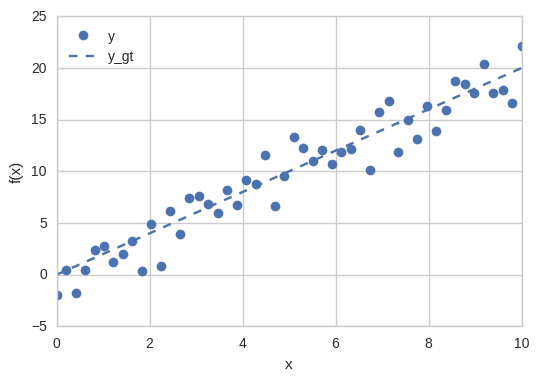

In [9]:
N = 50
x = np.linspace(0,10,N)
n = np.random.normal(scale=2,size=x.shape) # Gaussian noise with mean 0 and standard deviation 2
y    = f(x,m_gt,n)
y_gt = f(x,m_gt,0) # true line without noise
plot_f(x,y,y_gt)

## Closed-form solution

Which line (slope) explains the data "best"?
To answer that, we need to assign a cost to each slope $m$,
here based on the _mean squared error_ (MSE):

$$
\large
\def\x{{\bf x}}
\def\y{{\bf y}}
\def\tr{^\mathsf{T}}
C(m) = \frac{1}{N} \sum\nolimits_i (y_i - m \cdot x_i)^2
$$

Now find the "best" slope $\hat{m}$ that minimizes the cost function:

$$
\large
\hat{m}
\quad=\quad \mathsf{arg\,min}_m C(m)
\quad=\quad \mathsf{arg\,min}_m \lVert \y - m \cdot \x \rVert^2_2
\quad=\quad \color{blue}{(\x\tr\x)^{-1}(\x\tr\y)}
$$

m_hat = 1.97949 with cost C(m_hat) = 2.92009


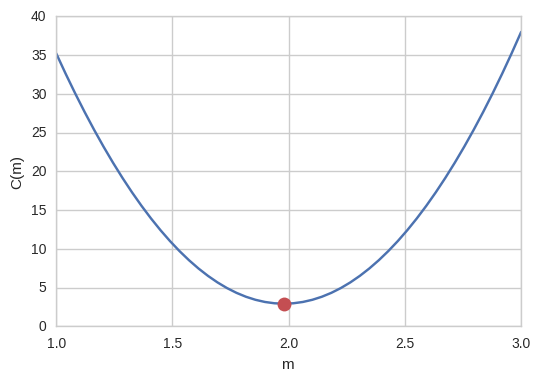

In [10]:
def C(m):
    return np.mean( (y-m*x)**2 )

m_candidates = np.linspace(m_gt-1,m_gt+1)
plt.plot(m_candidates,map(C,m_candidates)); plt.xlabel('m'); plt.ylabel('C(m)');

m_hat = x.dot(y) / x.dot(x) # closed-form solution
print 'm_hat = %g with cost C(m_hat) = %g' % (m_hat, C(m_hat))
plt.plot(m_hat,C(m_hat),'o',color=colors[2],markersize=10);

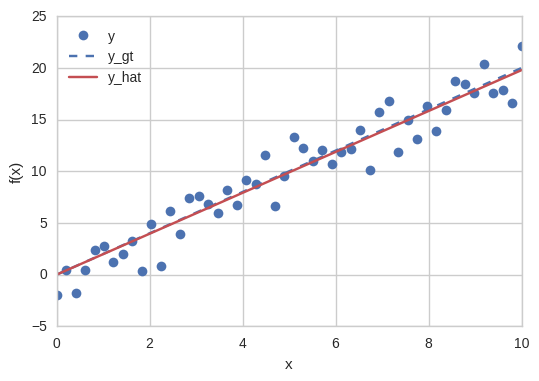

In [11]:
plot_f(x,y,y_gt,y_hat=f(x,m_hat,0))

## Iterative solution

### [Keras](https://keras.io/)

- sequential vs. functional model API
- loss and optimizer
- training: batch_size, epoch
- use model for prediction
- inspect learned model

### Define the model

Three ways to define the same model of a line that passes through the origin:

In [12]:
def get_model():
    model = Sequential([
        Dense(1, use_bias=False, input_shape=(1,), name='y'),
    ])
    return model

model = get_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
y (Dense)                    (None, 1)                 1         
Total params: 1
Trainable params: 1
Non-trainable params: 0
_________________________________________________________________


In [13]:
def get_model():
    model = Sequential()
    model.add( Dense(1, use_bias=False, input_shape=(1,), name='y') )
    return model

model = get_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
y (Dense)                    (None, 1)                 1         
Total params: 1
Trainable params: 1
Non-trainable params: 0
_________________________________________________________________


In [14]:
def get_model():
    l_in  = Input(shape=(1,),    name='x')
    l_out = Dense(1, use_bias=False, name='y')(l_in)
    model = Model(inputs=l_in,outputs=l_out)
    return model

model = get_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
x (InputLayer)               (None, 1)                 0         
_________________________________________________________________
y (Dense)                    (None, 1)                 1         
Total params: 1
Trainable params: 1
Non-trainable params: 0
_________________________________________________________________


### Choose a loss and optimizer

In [15]:
def compile_model(model):
    model.compile(loss='mean_squared_error',optimizer=Adam(0.01))

compile_model(model)

### Training

In [16]:
model.fit(x,y,batch_size=N,epochs=10);

Epoch 1/10
50/50 [==============================] - 1s - loss: 465.8344
Epoch 2/10
50/50 [==============================] - 0s - loss: 463.9782
Epoch 3/10
50/50 [==============================] - 0s - loss: 461.8415
Epoch 4/10
50/50 [==============================] - 0s - loss: 459.5829
Epoch 5/10
50/50 [==============================] - 0s - loss: 457.2585
Epoch 6/10
50/50 [==============================] - 0s - loss: 454.8950
Epoch 7/10
50/50 [==============================] - 0s - loss: 452.5070
Epoch 8/10
50/50 [==============================] - 0s - loss: 450.1034
Epoch 9/10
50/50 [==============================] - 0s - loss: 447.6905
Epoch 10/10
50/50 [==============================] - 0s - loss: 445.2720


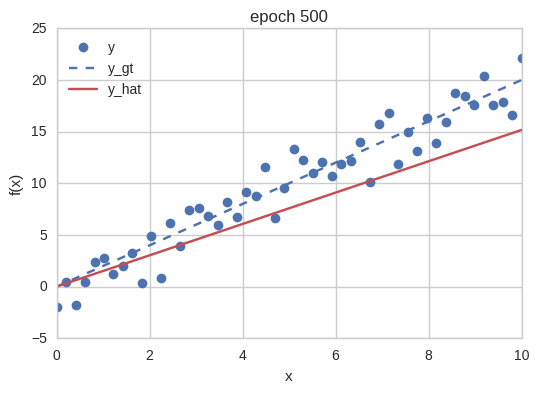

In [17]:
model.fit(x,y,batch_size=N,epochs=500,verbose=0,
          callbacks=[plot_callback(lambda:plot_f(x,y,y_gt,model.predict(x)))]);

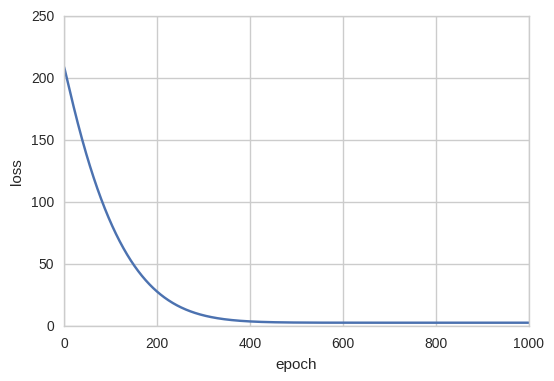

In [18]:
model = get_model()
compile_model(model)

hist = model.fit(x,y,batch_size=N,epochs=1000,verbose=False)
plot_loss(hist)

### Prediction and inspection

In [19]:
weights = model.get_layer('y').get_weights()
print 'weights =', weights # m_hat = weights[0][0][0]
print 'loss =', hist.history['loss'][-1]

weights = [array([[ 1.97945678]], dtype=float32)]
loss = 2.92008876801


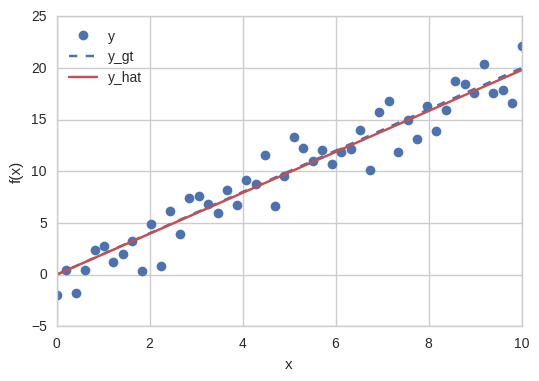

In [20]:
plot_f(x,y,y_gt,model.predict(x))

### Larger & deeper model → more powerful?

In [21]:
model = Sequential()
model.add( Dense(16, input_shape=(1,)) )
model.add( Dense(16) )
model.add( Dense(1, name='y') )
model.summary()
compile_model(model)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 16)                32        
_________________________________________________________________
dense_2 (Dense)              (None, 16)                272       
_________________________________________________________________
y (Dense)                    (None, 1)                 17        
Total params: 321
Trainable params: 321
Non-trainable params: 0
_________________________________________________________________


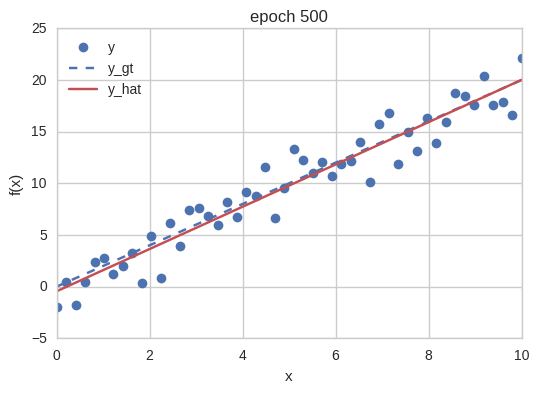

In [22]:
model.fit(x,y,batch_size=N,epochs=500,verbose=0,
          callbacks=[plot_callback(lambda:plot_f(x,y,y_gt,model.predict(x)))]);

### Activation functions

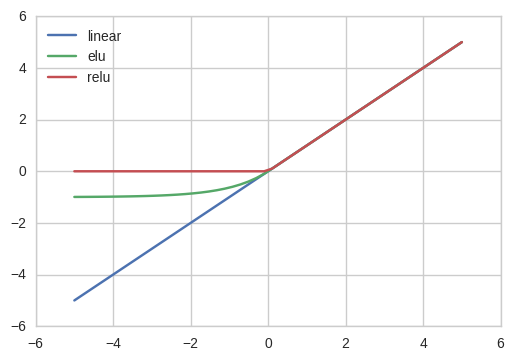

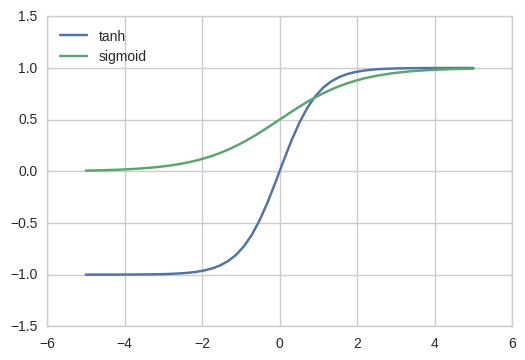

In [23]:
v = np.linspace(-5,5)
Identity = keras.layers.Lambda(lambda x: x+0,input_shape=(1,)) # to avoid an issue in keras
def plot_activations(activations_names):
    plt.figure()
    for name in activations_names:
        model = Sequential([Identity,Activation(name)])
        plt.plot(v,model.predict(v))    
    plt.legend(activations_names,loc='upper left')

plot_activations(('linear','elu','relu'))
plot_activations(('tanh','sigmoid')); plt.ylim((-1.5,1.5));

### Larger & deeper model → more powerful with non-linear activation functions

In [24]:
activation_name = 'tanh'
model = Sequential()
model.add( Dense(16, input_shape=(1,)) )
model.add( Activation(activation_name) )
model.add( Dense(16) )
model.add( Activation(activation_name) )
model.add( Dense(1, name='y') )
model.summary()
compile_model(model)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 16)                32        
_________________________________________________________________
activation_6 (Activation)    (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 16)                272       
_________________________________________________________________
activation_7 (Activation)    (None, 16)                0         
_________________________________________________________________
y (Dense)                    (None, 1)                 17        
Total params: 321
Trainable params: 321
Non-trainable params: 0
_________________________________________________________________


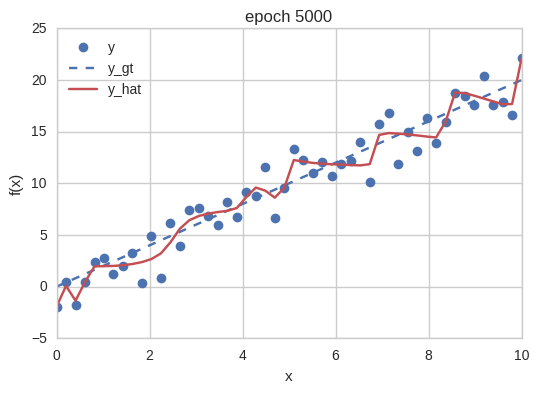

In [25]:
model.fit(x,y,batch_size=N,epochs=5000,verbose=0,
          callbacks=[plot_callback(lambda:plot_f(x,y,y_gt,model.predict(x)),200)]);

# Non-linear Regression

## Data

In [26]:
def f(x,n=0):
    return x * np.sin(x) + n

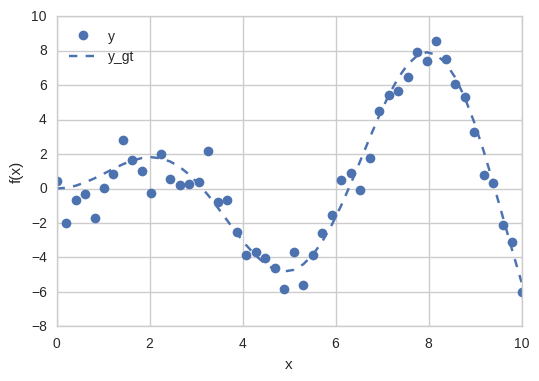

In [27]:
N = 50
x = np.linspace(0,10,N)
n = np.random.normal(scale=1,size=x.shape)
y    = f(x,n)
y_gt = f(x,0)
plot_f(x,y,y_gt)

## Model fitting

In [28]:
l_in  = Input(shape=(1,), name='x')
t = l_in
nlayers = 2
for i in range(nlayers):
    t = Dense(8, name='layer_%d'%(i+1))(t)
    t = Activation('elu', name='layer_%d_act'%(i+1))(t)
l_out = Dense(1, name='y')(t)
model = Model(inputs=l_in,outputs=l_out)
model.summary()
compile_model(model)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
x (InputLayer)               (None, 1)                 0         
_________________________________________________________________
layer_1 (Dense)              (None, 8)                 16        
_________________________________________________________________
layer_1_act (Activation)     (None, 8)                 0         
_________________________________________________________________
layer_2 (Dense)              (None, 8)                 72        
_________________________________________________________________
layer_2_act (Activation)     (None, 8)                 0         
_________________________________________________________________
y (Dense)                    (None, 1)                 9         
Total params: 97
Trainable params: 97
Non-trainable params: 0
_________________________________________________________________


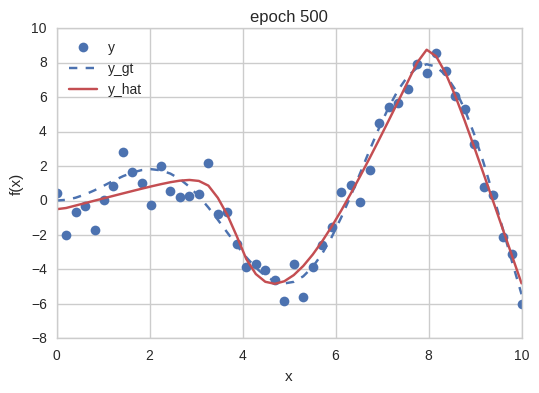

In [29]:
hist = model.fit(x, y, batch_size=N/1, epochs=500,verbose=0,
                 callbacks=[plot_callback(lambda: plot_f(x,y,y_gt,model.predict(x)), 20)]);

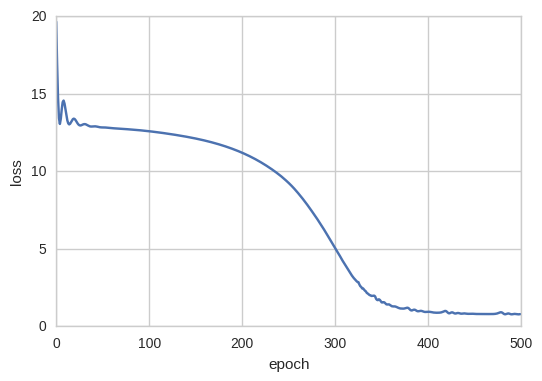

In [30]:
plot_loss(hist)

## Prediction and visualization

Prediction for unseen data points:

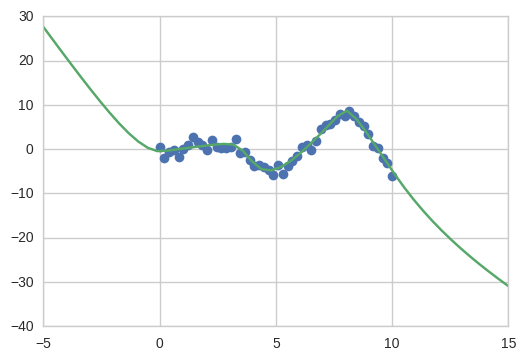

In [31]:
xx = np.linspace(-5,15)
plt.plot(x,y,'o')
plt.plot(xx,model.predict(xx));

Implicitly learned basis functions:

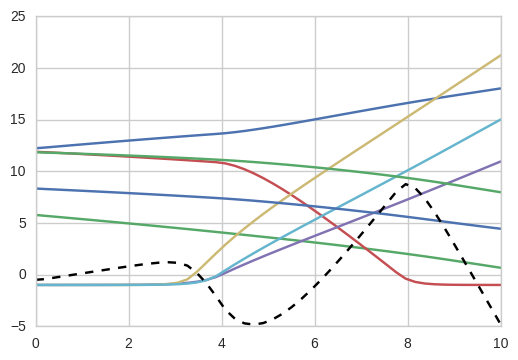

In [32]:
model_vis = Model(model.input, model.get_layer('layer_%d_act'%nlayers).output)
plt.plot(x,model_vis.predict(x));
plt.plot(x,model.predict(x),'--k');